<a href="https://colab.research.google.com/github/tablehan/deepLearningPractice/blob/main/LSTMforCCI30_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
#import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import time
import datetime
import os
print(os.path.abspath(''))

/content


In [2]:
# 從網路直接抓cci30過來測試建模
df=pd.read_csv("https://cci30.com/ajax/getIndexHistory.php",index_col=0).iloc[::-1,:]
print(df.shape)
# 空值處理
print(df.isnull().sum())
print(df[df["Volume"].isnull()])
# 取前後兩日差平均差補
df.loc['2020-11-30','Volume']=(df.loc['2020-12-01','Volume']+df.loc['2020-11-29','Volume'])/2
print(df.loc[['2020-11-29','2020-11-30','2020-12-01'],:])
# 排除成交量為0者
# exclude periods that valume=0
df=df[df['Volume']>0]
print(df.shape)

(2840, 5)
Open      0
High      0
Low       0
Close     0
Volume    1
dtype: int64
               Open     High      Low   Close  Volume
Date                                                 
2020-11-30  6327.62  6807.17  6270.84  6746.8     NaN
               Open     High      Low    Close        Volume
Date                                                        
2020-11-29  6270.79  6498.38  6133.79  6407.27  9.380875e+10
2020-11-30  6327.62  6807.17  6270.84  6746.80  1.127981e+11
2020-12-01  6748.96  6899.90  6220.79  6394.38  1.317874e+11
(1685, 5)


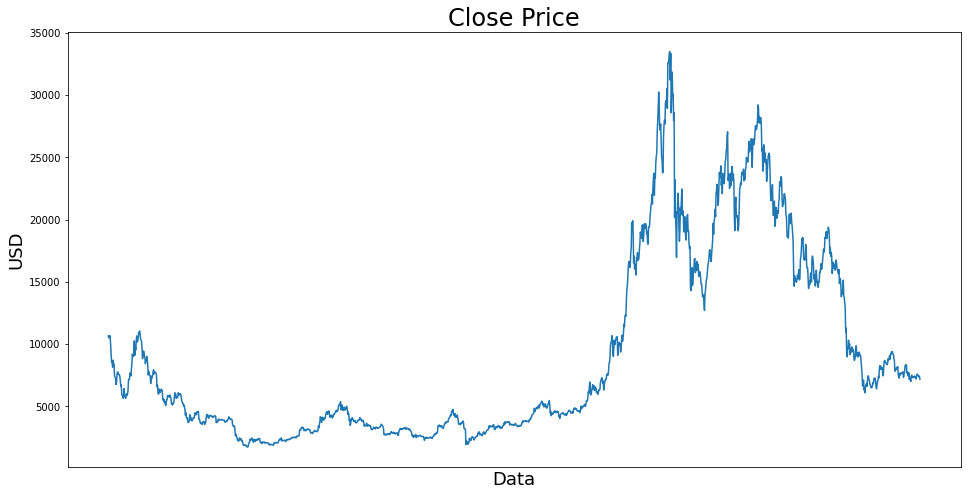

In [3]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

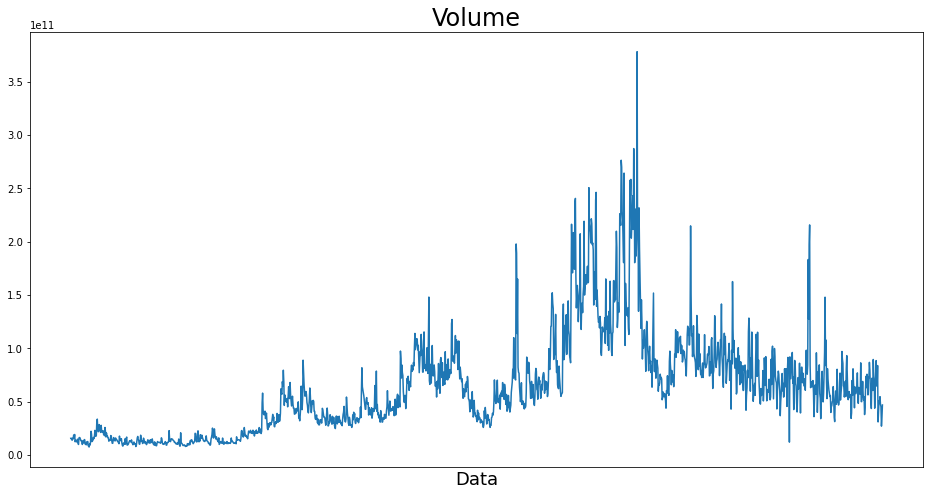

In [5]:
plt.figure(figsize=(16,8))
plt.title('Volume', fontsize=24)
plt.plot(df['Volume'])
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.show()

In [6]:
# Get the number of rows to train the model on. we need this number to create our train and test sets
# math.ceil will round up the number
training_data_len = math.ceil(df.shape[0] * .8) # We are using %80 of the data for training
training_data_len

1348

In [7]:
# Scale the data with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)
print(scaled_data)

[[0.26718113 0.27445008 0.28023588 0.28102918 0.02205259]
 [0.28119915 0.27450425 0.28790962 0.27647164 0.0224575 ]
 [0.27647607 0.27319202 0.28864061 0.27661967 0.0184771 ]
 ...
 [0.17948674 0.17181861 0.18956066 0.1772507  0.05288526]
 [0.17731488 0.17147069 0.18996552 0.17920789 0.07456258]
 [0.17927186 0.17216834 0.18472885 0.17143582 0.10640507]]


In [8]:
# hyper param
timeStep=10
batch_size=4
epochs=100
d=0.2

In [9]:
# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]

#Split the data into X_train and y_train data sets
X_train = np.array([train_data[i-timeStep:i,:] for i in range(timeStep, len(train_data))])
y_train = np.array([train_data[i,:] for i in range(timeStep, len(train_data))])
print(f'X_train shape:{X_train.shape}',f'y_train_shape: {y_train.shape}')

X_train shape:(1338, 10, 5) y_train_shape: (1338, 5)


In [10]:
# Create the testing dataset
# Create a new array containing scaled values from index 1335
test_data = scaled_data[training_data_len - timeStep : , :]
test_data
X_test = np.array([test_data[i-timeStep: i,:] for i in range(timeStep,len(test_data))])
y_test = np.array([test_data[i,:] for i in range(timeStep, len(test_data))])
print(f'X_test shape:{X_test.shape}',f'y_test_shape: {y_test.shape}')

X_test shape:(337, 10, 5) y_test_shape: (337, 5)


In [11]:
# Build LSTM model
tf.random.set_seed(42)
model_1 = Sequential()
model_1.add(LSTM(64, return_sequences=True, input_shape=(timeStep, X_train.shape[-1])))
model_1.add(Dropout(d))
model_1.add(LSTM(64, return_sequences=False))
model_1.add(Dropout(d))
model_1.add(Dense(32))
model_1.add(Dense(5))

In [12]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 53,189
Trainable params: 53,189
Non-traina

In [13]:
# Train the model
start_fix_time=datetime.datetime.now()
print(start_fix_time)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(X_test,y_test))

end_fix_time=datetime.datetime.now()
print(end_fix_time)

2022-10-12 06:31:48.224180
Epoch 1/100
335/335 - 12s - loss: 0.0050 - val_loss: 0.0040 - 12s/epoch - 35ms/step
Epoch 2/100
335/335 - 2s - loss: 0.0024 - val_loss: 0.0034 - 2s/epoch - 5ms/step
Epoch 3/100
335/335 - 2s - loss: 0.0023 - val_loss: 0.0015 - 2s/epoch - 5ms/step
Epoch 4/100
335/335 - 2s - loss: 0.0018 - val_loss: 0.0016 - 2s/epoch - 5ms/step
Epoch 5/100
335/335 - 2s - loss: 0.0019 - val_loss: 0.0021 - 2s/epoch - 5ms/step
Epoch 6/100
335/335 - 2s - loss: 0.0020 - val_loss: 0.0016 - 2s/epoch - 6ms/step
Epoch 7/100
335/335 - 2s - loss: 0.0018 - val_loss: 0.0012 - 2s/epoch - 5ms/step
Epoch 8/100
335/335 - 2s - loss: 0.0017 - val_loss: 0.0014 - 2s/epoch - 5ms/step
Epoch 9/100
335/335 - 2s - loss: 0.0016 - val_loss: 0.0095 - 2s/epoch - 5ms/step
Epoch 10/100
335/335 - 2s - loss: 0.0017 - val_loss: 0.0012 - 2s/epoch - 5ms/step
Epoch 11/100
335/335 - 2s - loss: 0.0014 - val_loss: 0.0014 - 2s/epoch - 5ms/step
Epoch 12/100
335/335 - 2s - loss: 0.0017 - val_loss: 0.0011 - 2s/epoch - 5ms/

<function matplotlib.pyplot.show(*args, **kw)>

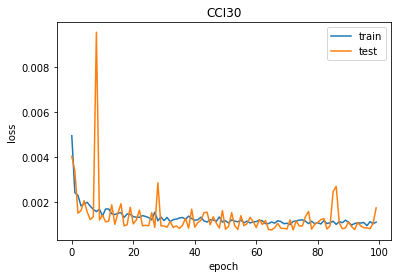

In [14]:
# plot the loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('CCI30',fontsize='12')
plt.ylabel('loss',fontsize='10')
plt.xlabel('epoch',fontsize='10')
plt.legend()
plt.show

In [17]:
# 儲存模型與scaler
model_1.save('models/bdse27_lstm_model_20221012cci30.h5')
import joblib
joblib.dump(scaler,'models/scaler_20221012cci30_5.save')
# Load it 
#scaler = joblib.load('scaler_cci30_5.save') 

['models/scaler_20221012cci30_5.save']

In [19]:
# 讀取scaler 
scaler = joblib.load('models/scaler_20221012cci30_5.save') 
model_1 = tf.keras.models.load_model('models/bdse27_lstm_model_20221012cci30.h5')
# 讀取模型

In [20]:
# Get the model_1 predicted price values 
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
predictions_1[:5,:]

array([[2.8502430e+04, 3.0563955e+04, 2.8044338e+04, 2.9981537e+04,
        1.0216189e+11],
       [2.9440215e+04, 3.1608125e+04, 2.8927416e+04, 3.0956592e+04,
        1.1617518e+11],
       [2.9563986e+04, 3.1694234e+04, 2.9123166e+04, 3.1100701e+04,
        1.0960264e+11],
       [2.8881705e+04, 3.1205918e+04, 2.8126322e+04, 3.0371447e+04,
        1.3676706e+11],
       [2.8391303e+04, 3.0413982e+04, 2.8024385e+04, 2.9882059e+04,
        1.0267982e+11]], dtype=float32)

In [21]:
#plotting param
dic={0:"Open",1:"High",2:"Low",3:"Close",4:"Volume"}
nums=0

In [22]:
# measure
from sklearn.metrics import mean_squared_error, r2_score
y_inver=scaler.inverse_transform(y_test)
for i in dic.keys():
  MAE=mean_squared_error(predictions_1[i], y_inver[i])
  R2=r2_score(predictions_1[i], y_inver[i])
  print(f'{dic[i]}: Mean Absolute Error={MAE} , | R2={R2}')
MAE=mean_squared_error(predictions_1, y_inver)
R2=r2_score(predictions_1, y_inver)
print(f'Total: Mean Absolute Error={MAE} , | R2={R2}')

Open: Mean Absolute Error=7.070923226393176e+18 , | R2=0.9957657297546761
High: Mean Absolute Error=1.8758068580616675e+19 , | R2=0.9913135645701303
Low: Mean Absolute Error=2.0373781020121632e+20 , | R2=0.8939990324901611
Close: Mean Absolute Error=3.747197376068007e+20 , | R2=0.874794411107207
Volume: Mean Absolute Error=5.941001435550788e+19 , | R2=0.9647815945469143
Total: Mean Absolute Error=7.962398229530126e+19 , | R2=0.7137435697258553


Text(0.5, 0, 'epochs')

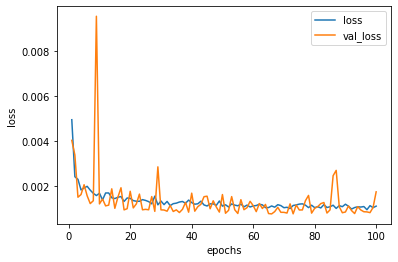

In [23]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [ ]:
# reference
# https://github.com/Ali619/Bitcoin-Price-Prediction-LSTM/blob/master/Bitcoin_Price_Prediction.ipynb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


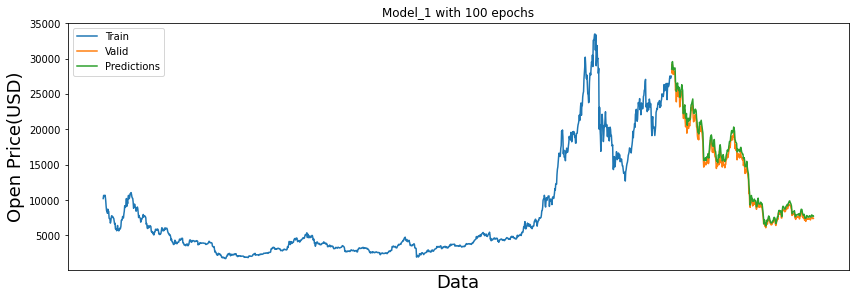

In [24]:
# Plot the data
train = df.iloc[:training_data_len]
# data for model_1
valid_1 = df.iloc[training_data_len:,:]
valid_1['Predictions'] = predictions_1[:,nums]

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title(f'Model_1 with {epochs} epochs')
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.ylabel(f'{dic[nums] if nums==4 else dic[nums]+" Price(USD)"}', fontsize=18)
plt.plot(train[dic[nums]])
plt.plot(valid_1[[dic[nums],"Predictions"]])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

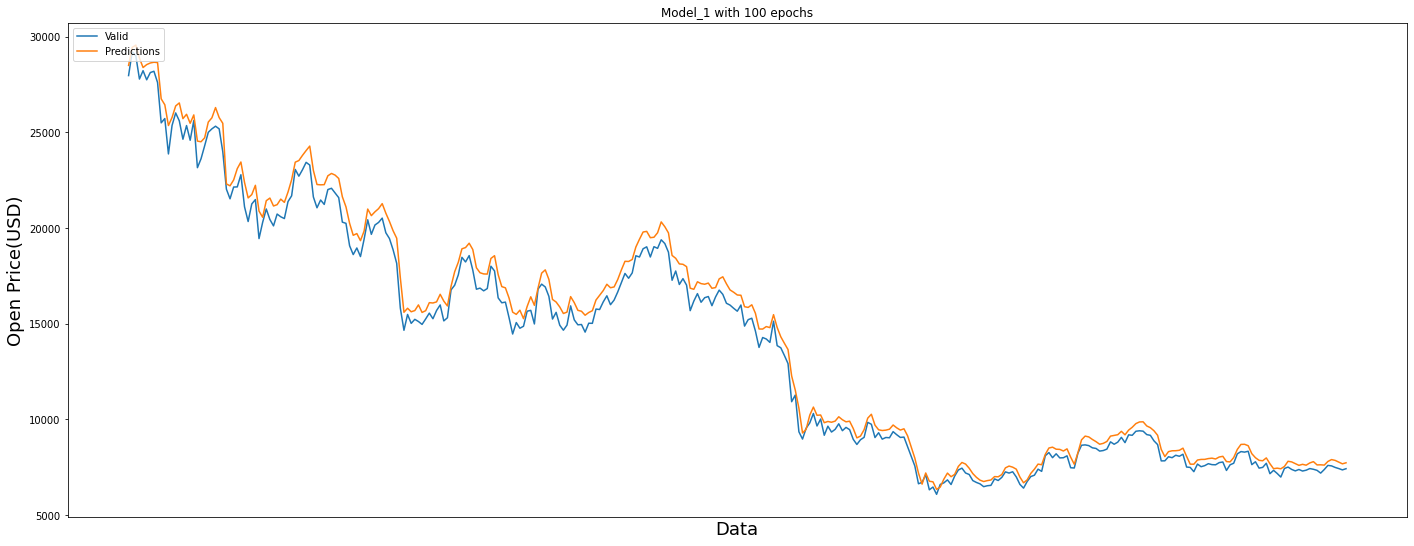

In [25]:
plt.figure(figsize=(24, 20))
plt.subplot(2, 1, 1)
plt.title(f'Model_1 with {epochs} epochs')
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.ylabel(f'{dic[nums] if nums==4 else dic[nums]+" Price(USD)"}', fontsize=18)
plt.plot(valid_1[[dic[nums],"Predictions"]])
plt.legend(['Valid', 'Predictions'], loc='upper left')

In [27]:
# 建構最後一個X作為預測新值的開始
last_data = df[-timeStep:]
last_date = datetime.datetime.strptime(last_data.index[-1],"%Y-%m-%d")
print(last_date)
future_periods=10

for _ in range (future_periods):
  #print(last_data.iloc[-1,:])
  pred_data=last_data[-timeStep:]

# Scale the data to be values between 0 and 1
  pred_data_scaled = scaler.fit_transform(pred_data.values)

  new_X_test = np.array(pred_data_scaled).reshape(1,pred_data_scaled.shape[0],pred_data_scaled.shape[1])

  pred_ = model_1.predict(new_X_test)
# Undo the scaling
  pred = scaler.inverse_transform(pred_)
  last_date = last_date + datetime.timedelta(days=1)
  pred = pd.DataFrame(pred,
        columns= ["Open","High","Low","Close","Volume"],
        index =["*"+datetime.datetime.strftime(last_date,"%Y-%m-%d")]
        )
  last_data=pd.concat([last_data,pred],axis=0)
print(last_data)

2022-10-10 00:00:00
                    Open         High          Low        Close        Volume
2022-10-01   7393.980000  7462.710000  7271.020000  7338.080000  3.092161e+10
2022-10-02   7338.230000  7410.600000  7167.420000  7193.710000  3.996133e+10
2022-10-03   7193.760000  7426.140000  7137.130000  7382.340000  5.096589e+10
2022-10-04   7381.950000  7649.290000  7339.000000  7597.500000  4.966518e+10
2022-10-05   7596.970000  7652.790000  7405.740000  7571.450000  5.462226e+10
2022-10-06   7571.540000  7700.570000  7447.710000  7489.720000  4.716327e+10
2022-10-07   7490.690000  7569.460000  7327.140000  7431.520000  4.516505e+10
2022-10-08   7430.880000  7475.870000  7310.820000  7361.980000  2.699935e+10
2022-10-09   7361.950000  7464.310000  7323.060000  7424.120000  3.503491e+10
2022-10-10   7424.060000  7487.490000  7164.740000  7177.360000  4.683860e+10
*2022-10-11  7260.541504  7464.059082  7185.683105  7251.239746  3.457303e+10
*2022-10-12  7245.652832  7452.124512  7175.